### Import packages for the simulation

In [1]:
# Normal staple packages
import sys 
import numpy as np
from numpy import pi as pi, sin as sin, cos as cos, tan as tan, arctan as arctan, arccos as arccos, arcsin as arcsin, exp as exp, log as log, sqrt as sqrt
%matplotlib inline 
# notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


import scipy.io as sio

# Bloch simulator 
from bloch.bloch import bloch
from bloch.min_time_gradient import minimum_time_gradient

# Biot Savart
sys.path.append('biot-savart-master')
import biot_savart_v4_3 as bs

### Define the grid of spins for our simulation. 

In [21]:
class SpinGrid:
    height = 10 # height of the grid in cm 
    width = 10 # width of the grid in cm
    flow_rate = 5 # flow rate in cm/s. assume vertical flow, with positive corresponding to going up. 
    # area of the grid where the flow is present given by a min and max x coordinate.
    # assume that all flowing material is blood, the rest is muscle. 
    flow_region = [-2, 2] 
    delta_x = 0.1 # grid spacing in cm
    delta_y = 0.1 # grid spacing in cm
    coil_file= None # file containing the shape of the coil, will be used to generate the coil field. 
    
    # TODO: fill in appropraite T1s, and name of other material. 
    T1_moving = -1 
    T2_moving = -1
    T1_static = 2
    T2_static = 2
    M_0 = 1 # initial magnetization of fresh spins 


    def __init__(self, height, width, flow_rate, flow_region, delta_x, delta_y):
        self.height = height
        self.width = width
        self.flow_rate = flow_rate
        self.flow_region = flow_region
        self.delta_x = delta_x
        self.delta_y = delta_y

        # create a grid of positions,and magnetizations. Additionally, calculate 
        # a list of indices for the flowing vs. static columns. 
        self.n_spins_x = int(self.width / self.delta_x)
        self.n_spins_y = int(self.height / self.delta_y)
        x_positions = np.linspace(-self.width/2, self.width/2, self.n_spins_x)
        y_positions = np.linspace(-self.height/2, self.height/2, self.n_spins_y)

        # Create a n_spins_x by n_spins_y grid of positions as the product of the x and y positions
        self.x_positions, self.y_positions = np.meshgrid(x_positions, y_positions)

        # Create the magnetizations 
        self.mxs = self.M_0 * np.zeros((self.n_spins_y, self.n_spins_x))
        self.mys = self.M_0 * np.zeros((self.n_spins_y, self.n_spins_x))
        self.mzs = self.M_0 * np.ones((self.n_spins_y, self.n_spins_x))
        
        # List of columns that are flowing 
        start_index = int((flow_region[0] - (-width/2)) / self.delta_x)
        end_index = int((flow_region[1] - (-width/2)) / self.delta_x)
        self.flowing_columns = np.array(range(start_index, end_index))
        self.static_columns = np.concatenate((np.array(range(0, start_index)), np.array(range(end_index, self.n_spins_x))))

        # Initialize the coil paths to be empty since we don't have desired coil origin yet.
        self.coil_paths = []


    def simulate_flow(self, delta_t):
        """ 
            Simulate the flow of blood through the grid
            delta_t: time to simulate in seconds
            
            Updates the grid by shifting the flowing columns appropriately. 
            Additionaly fills in fresh material in the space the flow has moved out of. 
        """
        # TODO: fill this in 
        pass

    
    def get_all_positions(self):
        """
            Return a 2 x num_spins array of all of the positions in the grid    
        """
        x_positions = self.x_positions.flatten()
        y_positions = self.y_positions.flatten()
        return np.vstack((x_positions, y_positions))

    def get_static_positions(self):
        """
            Return a 2 x num_static array of all of the positions of the static material   
        """
        all_positions = self.get_all_positions()
        return all_positions[:, self.static_columns]
    
    def get_moving_positions(self):
        """
            Return a 2 x num_moving array of all of the positions of the moving material    
        """
        all_positions = self.get_all_positions()
        return all_positions[:, self.flowing_columns] 


    def get_all_magnetizations(self):
        """
            Return a 2 x num_spins array of all of the magnetizations in the grid    
        """
        mxs = self.mxs.flatten()
        mys = self.mys.flatten()
        mzs = self.mzs.flatten()
        return mxs, mys, mzs
    
    def set_all_magnetizations(self, mxs, mys, mzs):
        """
            Set the magnetizations of the grid to the given mxs, mys, and mzs
        """
        self.mxs = mxs.reshape((self.n_spins_y, self.n_spins_x))
        self.mys = mys.reshape((self.n_spins_y, self.n_spins_x))
        self.mzs = mzs.reshape((self.n_spins_y, self.n_spins_x))

    def get_static_magnetizations(self):
        """
            Return a 2 x num_static array of the static magnetizations, indexed the same as the positions.    
        """
        all_magnetizations = self.get_all_magnetizations()
        return all_magnetizations[:, self.static_columns]
        
    def set_static_magnetizations(self, new_mxs, new_mys, new_mzs):
        """
            Take in a 1 x num_static array of magnetizations in the x, y, and z direction, and
            appropriately reshape and set the magnetizations of the spins in the static columns.
        """
        self.mxs[:, self.static_columns] = new_mxs.reshape((self.n_spins_y, len(self.static_columns)))
        self.mys[:, self.static_columns] = new_mys.reshape((self.n_spins_y, len(self.static_columns)))
        self.mzs[:, self.static_columns] = new_mzs.reshape((self.n_spins_y, len(self.static_columns)))

    def get_flowing_magnetizations(self):
        """
            Return a 2 x num_moving array of the moving magnetizations, indexed the same as the positions.
        """
        all_magnetizations = self.get_all_magnetizations()
        return all_magnetizations[:, self.flowing_columns]
    
    def set_flowing_magnetizations(self, new_mxs, new_mys, new_mzs):
        """
            Take in a 1 x num_moving array of magnetizations in the x, y, and z direction, and
            appropriately reshape and set the magnetizations of the spins in the moving columns.
        """
        self.mxs[:, self.flowing_columns] = new_mxs.reshape((self.n_spins_y, len(self.flowing_columns)))
        self.mys[:, self.flowing_columns] = new_mys.reshape((self.n_spins_y, len(self.flowing_columns)))
        self.mzs[:, self.flowing_columns] = new_mzs.reshape((self.n_spins_y, len(self.flowing_columns)))

    def visualize_grid(self):
        """
            Visualize the grid, and the flow region.
            Using the 2-d arrays x_position and y_position, plot a 
            circle at each position, with the color corresponding to the magnitude of the 
            x, y magnetization.
        """
        # Loop through the positions, and plot a circle at each position
        ax = plt.gca()
        ax.axis('equal')
        for i in range(self.n_spins_x):
            for j in range(self.n_spins_y):
                x = self.x_positions[j][i]
                y = self.y_positions[j][i]
                mx = self.mxs[j][i]
                my = self.mys[j][i]
                mz = self.mzs[j][i]

                # Plot a circle at x, y
                # ax.add_patch(plt.Circle((x, y), np.minimum(self.delta_x, self.delta_y), color=(mx, my, mz)))
                M_xy = np.sqrt(mx**2 + my**2) / self.M_0
                if i in self.flowing_columns:
                    circle = plt.Circle((x, y), self.delta_x/2, color = 0.2 * np.array([1, 0, 0]) + 0.8 * M_xy * np.array([1, 0, 0]))
                else:
                    circle = plt.Circle((x, y), self.delta_x/2, color = 0.2 * np.array([0, 0, 1]) + 0.8 * M_xy * np.array([0, 0, 1]))
                
                ax.add_patch(circle)

                # Plot a line showing the x, y magnetization. a line equal to the radius in the direction of mx, my.
                theta = np.arctan2(my, mx)
                plt.plot([x, x + self.delta_x/2 * np.cos(theta)], [y, y + self.delta_x/2 * np.sin(theta)], color='black')

        plt.xlim(-1.1*self.width/2, 1.1*self.width/2)
        plt.ylim(-1.1*self.height/2, 1.1*self.height/2)

        #ax.add_patch(plt.Circle((0, 0), 1.0, color='r'))

    def gen_save_coils(self, x, y):
        """
            Given position of coil, generate and save the coil geometries for 10 realistic current values
            for 
        """

        # create the indeces in radians for which to generate the coil. 10 loops so the range is 0 to 10*2*pi. 50*10 = 500 points total.
        pis = np.linspace(0,10*2*pi,500)

        # create a numpy list of x,y,z points of the coil based of the pis indeces. 
        # Make the coil 630um in diameter
        # center the coil around x, y
        # Add 4th dimension to represent current through the segment, set to 1 for now
        coil = np.array([315e-4*cos(pis)+x, 315e-4*sin(pis)+y, np.zeros(500), np.ones(500)]).T

        # create a  of 10 currerangent values from 50uA-700uA
        currents = np.linspace(50e-6,700e-6,10)

        # duplicate the coil 10 times, and multiply the right value of 1 by the respective current value generated above
        coils = [] 
        for current in currents:
            coiltoappend = coil.copy()
            coiltoappend[:,3] *= current
            coils.append(coiltoappend)


        # save the 10 coils in files in a folder called 'coils'. save them as text files with the current value in the name
        for i, coil in enumerate(coils):
            self.coil_paths.append('coils/coil_'+str(i)+'.txt')
            np.savetxt('coils/coil_'+str(i)+'.txt', coil, delimiter=", ")

    def compute_off_resonance_from_coil(self, coil_num):
        """
            Return a [num_spins x 1] array of the off resonance frequency of each spin, in Hz.
        """

        # TODO: right now we are just going to compute Bz of the coil for the positions in line of the coil. 
        # in the future extrapolate to 3 dimensions
        pos = self.get_all_positions()

        coil = bs.parse_coil(self.coil_paths[coil_num]) 
        chopped = bs.slice_coil(coil, 1)
        field = bs.calculate_field(chopped, pos[0], pos[1], [0]*len(pos[0]))
        self.df = field[:,2] * 4258 * 10e6
        
    def off_resonance_from_coil_static(self):
        """
            Return a [2 x num_static] array of the off resonance frequency of each static spin, in Hz.
        """
        pass

    def off_resonance_from_coil_moving(self):
        """
            Return a [2 x num_moving] array of the off resonance frequency of each moving spin, in Hz.
        """
        pass 

    def plot_coil_field(self):
        """
            Plot the field of the coil. 
        """
        pass

    def simulate_flow(self, delta_t):
            """ 
                Simulate the flow of blood through the grid
                delta_t: time to simulate in seconds
                
                Updates the positions appropriately. Despawns spins that pass out of the grid
                and then shifts the grid up appropriately.
                Additionally, adds in fresh spins if some have been despawned. 

                TODO: assumes flowing upwards for now, 
            """
            # Shift the position of all of the spins in the moving columns based on the 
            # flow rate and delta_t

            self.y_positions[:, self.flowing_columns] += self.flow_rate * delta_t


            # See which spins have moved out of the grid, and shift the grid up to copy over them.
            # we'll find the first y position that is greather than the height of the grid/2 + delta_y 
            y_positions_single_moving_column = self.y_positions[:, self.flowing_columns[0]]
            num_to_shift = np.sum(y_positions_single_moving_column > (self.height/2 + self.delta_y))
            if num_to_shift > 0:
                # Move things up in the matrix by num_to_shift, writing over the ones 
                # that are out of bounds 
                self.x_positions[num_to_shift:, self.flowing_columns] = self.x_positions[0:-num_to_shift, self.flowing_columns]
                self.y_positions[num_to_shift:, self.flowing_columns] = self.y_positions[0:-num_to_shift, self.flowing_columns]

                # Fill in fresh spins based on the number that we've shifted
                new_xs =  np.linspace(-self.width/2, self.width/2, self.n_spins_x)[self.flowing_columns]
                new_ys = np.linspace(-self.height/2, self.height/2, self.n_spins_y)[0:num_to_shift]
                meshgrid_x, meshgrid_y = np.meshgrid(new_xs, new_ys)

                self.x_positions[0:num_to_shift, self.flowing_columns] = meshgrid_x
                self.y_positions[0:num_to_shift, self.flowing_columns] = meshgrid_y
        
# Try creating a SpinGrid
spin_grid = SpinGrid(10, 10, 5, [-2, 2], 0.25, 0.25)
#spin_grid.visualize_grid()

# Have the grid flow
# spin_grid.simulate_flow(0.11)
#spin_grid.visualize_grid()

### Simulate and visualize flow on its own without imaging to make sure we can make things flow 


In [ ]:
# Create an animation of the grid flowing 
flow_dt = 0.005
fig, ax = plt.subplots()

def update(frame):
    plt.gca().clear()
    spin_grid.simulate_flow(flow_dt)
    spin_grid.visualize_grid()
    return plt.gca()

anim = FuncAnimation(fig, update, frames=range(3))
HTML(anim.to_jshtml())
anim.save("./temp.gif", writer='imagemagick', fps=15)

### Gen BZ from coil at desired positions

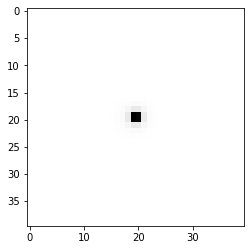

In [27]:
spin_grid.gen_save_coils(0,0)
spin_grid.compute_off_resonance_from_coil(9) 
plt.imshow(spin_grid.df.reshape((40,40)), cmap="gray")

In [26]:
np.set_printoptions(threshold=sys.maxsize)
print(spin_grid.get_all_positions().T)

[[-5.         -5.        ]
 [-4.74358974 -5.        ]
 [-4.48717949 -5.        ]
 [-4.23076923 -5.        ]
 [-3.97435897 -5.        ]
 [-3.71794872 -5.        ]
 [-3.46153846 -5.        ]
 [-3.20512821 -5.        ]
 [-2.94871795 -5.        ]
 [-2.69230769 -5.        ]
 [-2.43589744 -5.        ]
 [-2.17948718 -5.        ]
 [-1.92307692 -5.        ]
 [-1.66666667 -5.        ]
 [-1.41025641 -5.        ]
 [-1.15384615 -5.        ]
 [-0.8974359  -5.        ]
 [-0.64102564 -5.        ]
 [-0.38461538 -5.        ]
 [-0.12820513 -5.        ]
 [ 0.12820513 -5.        ]
 [ 0.38461538 -5.        ]
 [ 0.64102564 -5.        ]
 [ 0.8974359  -5.        ]
 [ 1.15384615 -5.        ]
 [ 1.41025641 -5.        ]
 [ 1.66666667 -5.        ]
 [ 1.92307692 -5.        ]
 [ 2.17948718 -5.        ]
 [ 2.43589744 -5.        ]
 [ 2.69230769 -5.        ]
 [ 2.94871795 -5.        ]
 [ 3.20512821 -5.        ]
 [ 3.46153846 -5.        ]
 [ 3.71794872 -5.        ]
 [ 3.97435897 -5.        ]
 [ 4.23076923 -5.        ]
 

### Create a sequence. 
This will correspond to: b1 (rf) [1 x M], gr (2xM), and readout_indices

In [ ]:
def create_ssfp_rf(dt, TR, theta=60):
    """
        Creates an RF pulse for a single TR of the ssfp sequence. TR_index 
        is included in case we want to change the angle depending on the TR. 
    """
    # Create an empty sequence, then calculate the magnitude of a single sample 
    # hard RF pulse to rotate by theta degrees 
    rf_seq = np.zeros(int(TR/dt))
    rf_mag = theta/360/(4257*dt)

    # Add in the magnitude to the first sample then return
    rf_seq[0] = rf_mag
    return rf_seq 


def create_ssfp_sequence(TR, dt, theta=60):
    """
        Create a single TR of an SSFP sequence that just does a single theta degree 
        RF pulse. 

        Returns rf_seq, grad_seq  
    """
    # Create the rf sequence 
    rf_seq = create_ssfp_rf(dt, TR, theta=theta)

    # Create the gradient sequence
    gx = 0 * rf_seq
    gy = 0 * rf_seq 
    grad_seq = np.vstack((gx, gy))

    return rf_seq, grad_seq


In [ ]:
# Create a single TR of the sequence and plot the RF pulse
TR = 2e-3 
dt = 4e-6
rf_seq, grad_seq = create_ssfp_sequence(TR, dt)

# Plot the RF pulse
plt.plot(dt * np.array(range(len(rf_seq))), rf_seq)

In [ ]:
len(rf_seq)

### Simulate the sequence 

In [ ]:
# Define all of the parameters for the simulation 
TR = 10e-3 # 2e-3 
dt = 4e-6
n_TRs = 200
T1 = 200e-3 # 0.83 
T2 = 100e-3 # 0.08
theta = 90

# Try creating a SpinGrid
spin_grid = SpinGrid(10, 10, 5, [-2, 2], 0.5, 0.5)
spin_grid.visualize_grid()

# Simulate forward through n_TRs, keeping track of the magnetizations at every point in time. 
signal = np.array([])

for i in range(n_TRs):
    # Get the rf and gradient sequence for this TR 
    rf_seq, grad_seq = create_ssfp_sequence(TR, dt, theta=theta)

    # On odd TRs, flip the sign of the rf sequence 
    if i % 2 == 1:
        rf_seq = -rf_seq

    mx, my, mz = spin_grid.get_all_magnetizations() 
    positions = spin_grid.get_all_positions()
    df = 0

    new_mx, new_my, new_mz = bloch(rf_seq, grad_seq, dt, T1, T2, df, positions, 2, mx, my, mz) # magnetizations are num_positions x num_times if no off resonance frequency 
    spin_grid.set_all_magnetizations(new_mx[:, -1], new_my[:, -1], new_mz[:, -1])

    current_signal = np.sum(new_mx, axis=0) + 1j*np.sum(new_my, axis=0)
    signal = np.append(signal, current_signal)

signal_strength = np.abs(signal)

In [ ]:
plt.plot(dt*np.array(range(len(signal_strength))) / TR, signal_strength / (spin_grid.n_spins_x*spin_grid.n_spins_y))

In [ ]:
?bloch

### Reconstruct an image

### Create a 